# Exploratory Data Analysis (EDA)

## 1. Data Loading

### 1.1 Import Libraries
Essential libraries for data manipulation and visualization.

In [20]:
# Standard Library
import os
import sys

# Add project root to system path (for relative imports to work)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Core Data Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from PIL import Image

# Project Configuration
from src import config

In [2]:
print(config.PROJECT_ROOT)

/Users/ramy/Desktop/team_project/BYU_Locating_Bacterial_Flagellar_Motors_2025


In [3]:
print(config.TRAIN_LABELS_PATH)

/Users/ramy/Desktop/team_project/BYU_Locating_Bacterial_Flagellar_Motors_2025/data/raw/train_labels.csv


### 1.2 Load Labels CSV
Read the training labels from the appropriate path using `pandas`.

In [4]:
# Load labels using the path defined in config.py
train_labels_path = config.TRAIN_LABELS_PATH

# Read the CSV file
labels = pd.read_csv(train_labels_path)

### 1.3 Preview Data
We display basic information about the dataset including:
- Number of unique tomograms.
- The shape of the DataFrame.
- A preview of the first few rows.

In [5]:
# Check number of unique tomograms
num_tomograms = labels['tomo_id'].nunique()
print(f"Number of unique tomograms in the training set: {num_tomograms}")

# Show shape and first few rows
print(f"Dataset contains {labels.shape[0]} rows and {labels.shape[1]} columns.")
labels.head()

Number of unique tomograms in the training set: 648
Dataset contains 737 rows and 10 columns.


,row_id,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors
0,0,tomo_003acc,-1.0,-1.0,-1.0,500,1912,1847,6.5,0
1,1,tomo_00e047,169.0,546.0,603.0,300,959,928,15.6,1
2,2,tomo_00e463,235.0,403.0,137.0,500,924,956,19.7,6
3,3,tomo_00e463,243.0,363.0,153.0,500,924,956,19.7,6
4,4,tomo_00e463,222.0,379.0,144.0,500,924,956,19.7,6


## 2. Missing Values and Data Types
Understanding the completeness and structure of the data is essential before modeling. This section examines:
- Missing values across columns
- Data types of each feature

### 2.1 Check for Missing Values
We inspect each column to see if there are any missing (`NaN`) values that may require imputation or special handling.

In [6]:
# Check for missing values in each column
missing_values = labels.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 row_id                  0
tomo_id                 0
Motor axis 0            0
Motor axis 1            0
Motor axis 2            0
Array shape (axis 0)    0
Array shape (axis 1)    0
Array shape (axis 2)    0
Voxel spacing           0
Number of motors        0
dtype: int64


### 2.2 Examine Data Types
We check the data types of each column to ensure they match our expectations (e.g., numerical vs. categorical).

In [7]:
# Display data types of all columns
data_types = labels.dtypes
print("Data types:\n", data_types)

Data types:
 row_id                    int64
tomo_id                  object
Motor axis 0            float64
Motor axis 1            float64
Motor axis 2            float64
Array shape (axis 0)      int64
Array shape (axis 1)      int64
Array shape (axis 2)      int64
Voxel spacing           float64
Number of motors          int64
dtype: object


## 3. Target Distribution (Number of Motors)
This section explores the distribution of the target variable — the number of motors in each tomogram.
Understanding class balance is important for model training and evaluation.

### 3.1 Frequency of Motor Counts
We begin by examining how frequently each motor count appears in the dataset.

In [8]:
# Count the frequency of each motor count
motor_counts = labels["Number of motors"].value_counts().sort_index()
print("Frequency of motor counts:\n", motor_counts)

Frequency of motor counts:
 Number of motors
0     286
1     313
2      56
3      18
4      36
6      18
10     10
Name: count, dtype: int64


### 3.2 Visualize the Distribution
We plot the distribution of the target variable using a bar chart to better understand class balance.

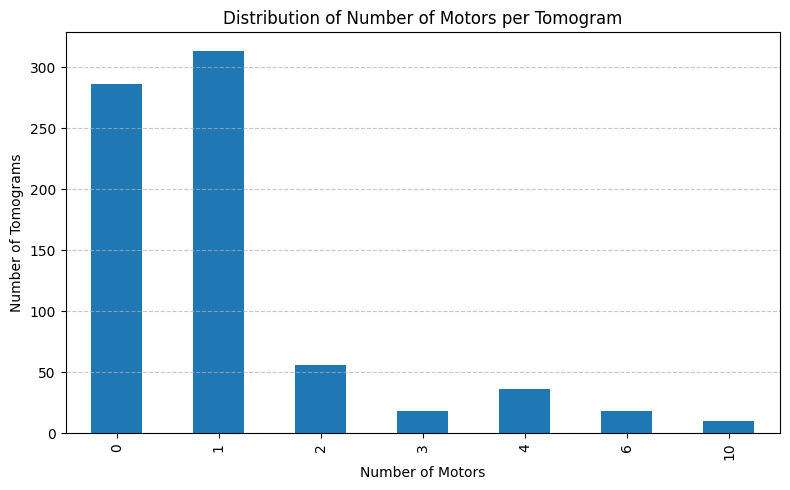

In [9]:
import matplotlib.pyplot as plt

# Plot the distribution
plt.figure(figsize=(8, 5))
motor_counts.plot(kind='bar')
plt.title("Distribution of Number of Motors per Tomogram")
plt.xlabel("Number of Motors")
plt.ylabel("Number of Tomograms")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 3.3 Box Plot of Motor Axis 0 by Number of Motors

This plot explores how the Z-axis coordinate of motors (`Motor axis 0`) varies across tomograms with different numbers of motors.
It helps reveal any spatial patterns, outliers, or labeling conventions in motor placement relative to tomogram depth.

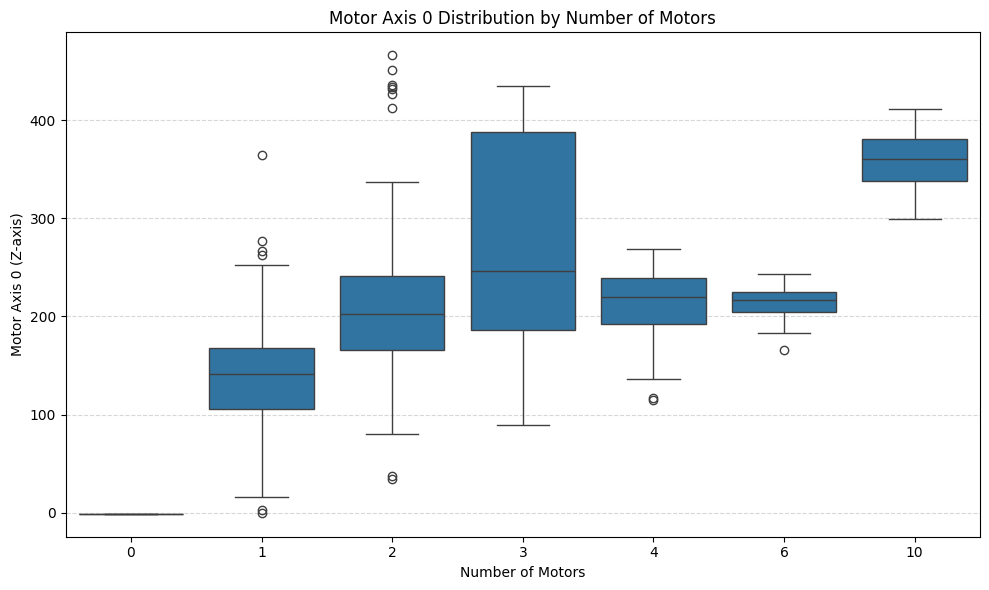

In [10]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='Number of motors', y='Motor axis 0', data=labels)
plt.title("Motor Axis 0 Distribution by Number of Motors")
plt.xlabel("Number of Motors")
plt.ylabel("Motor Axis 0 (Z-axis)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

The boxplot reveals the following:

- Tomograms labeled with `0` motors have Z-values near 0 or -1, confirming placeholder values used to indicate absence of motors.
- Tomograms with 1 to 4 motors show increasing variability in Z-coordinates, especially with 3 motors having the widest spread.
- Tomograms with 10 motors have more concentrated Z-coordinates in higher depth slices, hinting at possible structural or acquisition-related regularities.
- The presence of outliers across all classes suggests non-uniform spatial distribution and potentially noisy annotations.

## 4. Tomogram Shape & Voxel Spacing

In this section, we analyze the structural dimensions of each tomogram and the voxel spacing used to capture them. 
Understanding the variation in shape and scale is critical for preprocessing, normalization, and model input design.

We examine:
- The distribution of tomogram dimensions across the three axes (Z, Y, X).
- The voxel spacing (in angstroms per voxel), which determines the physical scale of the volumes.

### 4.1 Distribution of Tomogram Shapes

Each tomogram in the dataset is a 3D volume composed of multiple 2D image slices. 
This section examines the distributions of the array shape along each axis (`z`, `y`, `x`) 
to understand the size variability across samples.

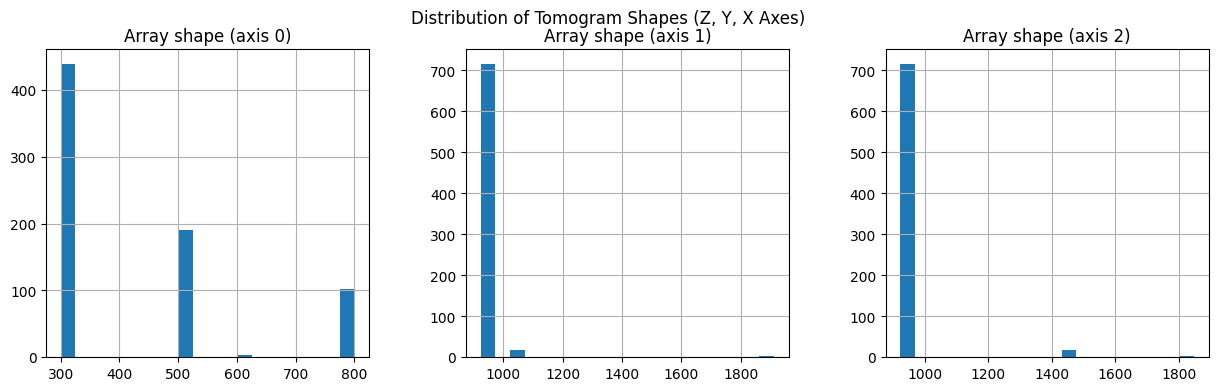

In [11]:
# Plot histograms for each axis dimension
shape_cols = ['Array shape (axis 0)', 'Array shape (axis 1)', 'Array shape (axis 2)']
labels[shape_cols].hist(bins=20, figsize=(15, 4), layout=(1, 3))
plt.suptitle("Distribution of Tomogram Shapes (Z, Y, X Axes)")
plt.show()

### 4.2 Voxel Spacing Distribution

Voxel spacing represents the real-world scale (in angstroms) of each voxel.

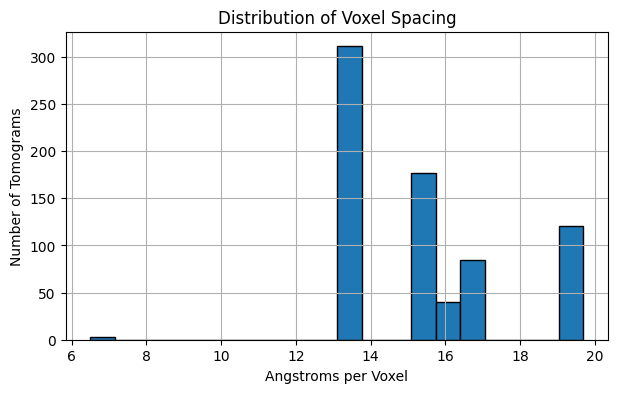

In [12]:
# Histogram of voxel spacing
plt.figure(figsize=(7, 4))
plt.hist(labels["Voxel spacing"], bins=20, edgecolor='black')
plt.title("Distribution of Voxel Spacing")
plt.xlabel("Angstroms per Voxel")
plt.ylabel("Number of Tomograms")
plt.grid(True)
plt.show()

### 4.3 Observations

**Tomogram Shape (Axes 0, 1, 2):**

- **Axis 0 (Z-axis / depth)** shows discrete modes centered around 300, 500, and 800 slices, indicating tomograms come in a few fixed depth configurations.
- **Axis 1 and 2 (Y and X axes / height and width)** are much more consistent, with most tomograms around 960–1000 pixels in both dimensions. A small number extend beyond 1400 and 1800, likely outliers or different imaging settings.

**Voxel Spacing:**

- Voxel spacing is **not uniform**. While the majority of tomograms have spacings near **13–16 Å per voxel**, a few samples go as low as **6.5 Å** or as high as **19.7 Å**.
- This variability suggests tomograms were acquired using different microscope settings or resolutions.

**Implications:**

- Coordinate values (`Motor axis 0/1/2`) must be **normalized by tomogram shape** to ensure comparability across samples.
- In some models (especially those considering spatial accuracy), voxel spacing should be factored in — either to scale coordinates into physical units or as an input feature.
- Tomograms with unusual shapes or voxel spacings may require special handling or exclusion, especially if their frequency is low.

## 5. Visual Inspection of Example Tomograms

Before training models, it's essential to visually understand the structure of the tomograms and how motors appear within them. 
In this section, we:
- Load a sample tomogram (as 2D slices)
- Display selected slices
- Overlay the motor location to verify annotation alignment

### 5.1 Load and Display Slices

Tomograms are stored as folders of 2D `.jpg` slices, ordered by their Z-index (`slice_0000.jpg`, `slice_0001.jpg`, ...). 
We load a sample tomogram and visualize its middle slices.

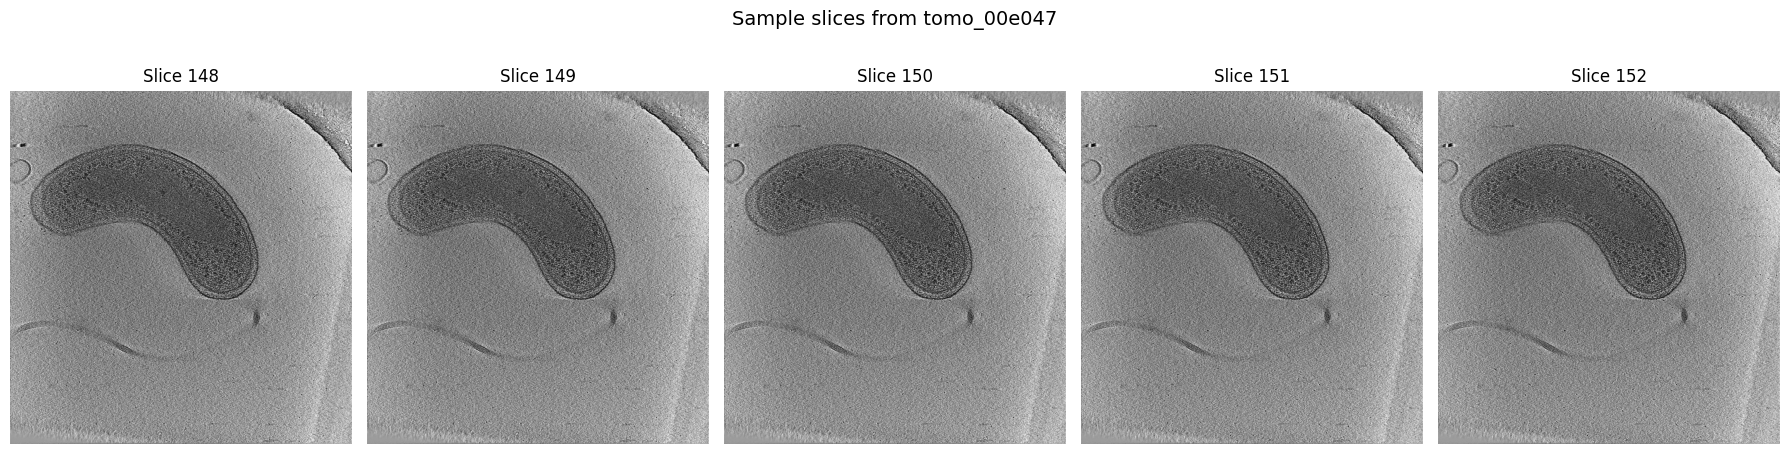

In [ ]:
# Choose a sample tomo_id known to contain a motor
sample_tomo_id = 'tomo_00e047'  # replace if needed
sample_dir = os.path.join(config.FULL_DATA_TRAIN_DIR, sample_tomo_id)

# Load sorted list of slice filenames
slices = sorted([f for f in os.listdir(sample_dir) if f.endswith('.jpg')])
num_slices = len(slices)

# Display 5 mid-range slices
mid_idx = num_slices // 2
selected_indices = [mid_idx - 2, mid_idx - 1, mid_idx, mid_idx + 1, mid_idx + 2]

fig, axes = plt.subplots(1, 5, figsize=(18, 5))
for ax, idx in zip(axes, selected_indices):
    img_path = os.path.join(sample_dir, slices[idx])
    img = Image.open(img_path)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Slice {idx}")
    ax.axis('off')

plt.suptitle(f"Sample slices from {sample_tomo_id}", fontsize=14)
plt.tight_layout()
plt.show()

### 5.2 Overlay Motor Coordinates on a Slice

We now highlight the motor position on the slice corresponding to its `Motor axis 0` value to visually confirm annotation accuracy.

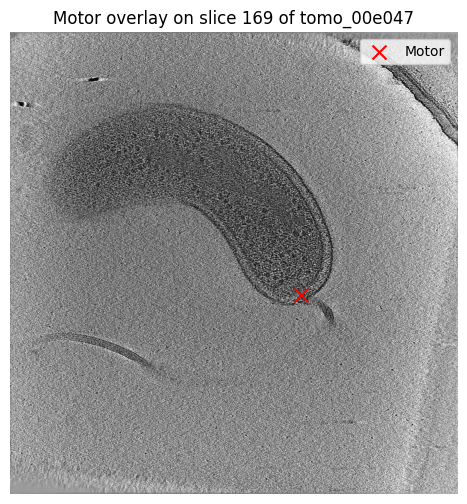

In [19]:
# Get motor location for the sample tomo
motor_row = labels[labels['tomo_id'] == sample_tomo_id].iloc[0]
z, y, x = int(motor_row['Motor axis 0']), motor_row['Motor axis 1'], motor_row['Motor axis 2']

# Load the image slice containing the motor
motor_slice = Image.open(os.path.join(sample_dir, f"slice_{z:04d}.jpg"))

# Plot with overlay
plt.figure(figsize=(6, 6))
plt.imshow(motor_slice, cmap='gray')
plt.scatter([x], [y], color='red', marker='x', s=100, label='Motor')
plt.title(f"Motor overlay on slice {z} of {sample_tomo_id}")
plt.legend()
plt.axis('off')
plt.show()

## 2. Data Description

We begin by loading the full training labels file and checking how many unique tomogram volumes (`tomo_id`) are available in the dataset. This helps quantify the number of distinct 3D bacterial scans present in the training data.

### 2.1 Dataset Columns

- **row_id** — Index of the row (unique per motor record).
- **tomo_id** — Unique identifier for each tomogram. One tomogram may have multiple motors, so it can appear in multiple rows.
- **Motor axis 0** — Z-coordinate of the motor (which 2D slice it is in).
- **Motor axis 1** — Y-coordinate of the motor.
- **Motor axis 2** — X-coordinate of the motor.
- **Array shape axis 0** — Z-axis length (number of slices in the tomogram).
- **Array shape axis 1** — Y-axis length (height of each 2D slice).
- **Array shape axis 2** — X-axis length (width of each 2D slice).
- **Voxel spacing** — Scaling factor; angstroms per voxel (physical spacing).
- **Number of motors** — Total number of motors in that tomogram. Note: each row corresponds to a single motor.

In [14]:
labels = pd.read_csv(train_labels_path)
print(labels['tomo_id'].nunique())

648


In [15]:
labels

,row_id,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors
0,0,tomo_003acc,-1.0,-1.0,-1.0,500,1912,1847,6.5,0
1,1,tomo_00e047,169.0,546.0,603.0,300,959,928,15.6,1
2,2,tomo_00e463,235.0,403.0,137.0,500,924,956,19.7,6
3,3,tomo_00e463,243.0,363.0,153.0,500,924,956,19.7,6
4,4,tomo_00e463,222.0,379.0,144.0,500,924,956,19.7,6
...,...,...,...,...,...,...,...,...,...,...
732,732,tomo_fe050c,138.0,134.0,542.0,300,959,928,15.6,1
733,733,tomo_fe85f6,-1.0,-1.0,-1.0,800,928,960,13.1,0
734,734,tomo_fea6e8,-1.0,-1.0,-1.0,300,960,928,16.8,0
735,735,tomo_ff505c,111.0,816.0,678.0,300,959,928,15.6,1


### 2.2 Missing Values and Data Types

We inspect the dataset for any missing values or inconsistencies, and review the data types to ensure they match the intended formats (e.g., numerical for coordinates, categorical for identifiers).

In [16]:
# Check for missing values
missing_values = labels.isna().sum()
print("Missing values per column:\n", missing_values)

# Check data types
print("\nData types:\n", labels.dtypes)

Missing values per column:
 row_id                  0
tomo_id                 0
Motor axis 0            0
Motor axis 1            0
Motor axis 2            0
Array shape (axis 0)    0
Array shape (axis 1)    0
Array shape (axis 2)    0
Voxel spacing           0
Number of motors        0
dtype: int64

Data types:
 row_id                    int64
tomo_id                  object
Motor axis 0            float64
Motor axis 1            float64
Motor axis 2            float64
Array shape (axis 0)      int64
Array shape (axis 1)      int64
Array shape (axis 2)      int64
Voxel spacing           float64
Number of motors          int64
dtype: object


## Distribution of Motor Counts per Tomogram

Next, we examine how many motors are present in each tomogram using the `Number of motors` column. This helps us understand the variation in annotations—some tomograms contain no motors at all, while others may contain multiple motors.

This information is useful for designing a balanced training and evaluation strategy, especially since the presence of zero-motor tomograms indicates negative examples.

In [17]:
print(labels['Number of motors'].value_counts())

Number of motors
1     313
0     286
2      56
4      36
6      18
3      18
10     10
Name: count, dtype: int64


In [18]:
import pandas as pd

# Load labels
df = pd.read_csv('byu-locating-bacterial-flagellar-motors-2025/train_labels.csv')

# Create a summary to count motors per tomogram
motor_counts = df.groupby('tomo_id')['Number of motors'].max().reset_index()
motor_counts.columns = ['tomo_id', 'motor_count']

# Categorize into bins
motor_counts['category'] = motor_counts['motor_count'].apply(
    lambda x: '1' if x == 1 else ('0' if x == 0 else '2+')
)

# Define sample sizes
sample_sizes = {'1': 30, '0': 15, '2+': 5}

# Sample per category
sampled_ids = []
for category, size in sample_sizes.items():
    subset = motor_counts[motor_counts['category'] == category]
    sampled = subset.sample(n=size, random_state=42)
    sampled_ids.extend(sampled['tomo_id'].tolist())

# Filter original labels to include only sampled tomograms
sampled_df = df[df['tomo_id'].isin(sampled_ids)]

# Save sampled labels
sampled_df.to_csv("sampled_train_labels.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'byu-locating-bacterial-flagellar-motors-2025/train_labels.csv'

In [ ]:
import os
import shutil

src_dir = "train"
dst_dir = "sampled_train"

os.makedirs(dst_dir, exist_ok=True)

for tomo_id in sampled_ids:
    src_path = os.path.join(src_dir, tomo_id)
    dst_path = os.path.join(dst_dir, tomo_id)
    if os.path.exists(src_path):
        shutil.copytree(src_path, dst_path)

In [ ]:
labels = pd.read_csv('sampled_train_labels.csv')
print(labels.head())
print(labels['tomo_id'].nunique(), 'unique tomograms')

   row_id      tomo_id  Motor axis 0  Motor axis 1  Motor axis 2  \
0      14  tomo_0363f2          50.0         574.0         392.0   
1      17  tomo_04d42b          -1.0          -1.0          -1.0   
2      23  tomo_072a16          -1.0          -1.0          -1.0   
3      32  tomo_0a8f05          52.0         587.0         575.0   
4      58  tomo_1446aa         149.0         293.0         601.0   

   Array shape (axis 0)  Array shape (axis 1)  Array shape (axis 2)  \
0                   300                   960                   928   
1                   500                  1024                  1440   
2                   300                   960                   928   
3                   300                   928                   928   
4                   300                   960                   928   

   Voxel spacing  Number of motors  
0           13.1                 1  
1           13.3                 0  
2           16.8                 0  
3           13.1

In [ ]:
import os
import shutil
import pandas as pd

# Load sampled labels
labels = pd.read_csv('sampled_train_labels.csv')
sampled_ids = labels['tomo_id'].unique()

# Define source (full dataset) and destination (sample)
src_root = "byu-locating-bacterial-flagellar-motors-2025/train"
dst_root = "sampled_train"

os.makedirs(dst_root, exist_ok=True)

for tomo_id in sampled_ids:
    src = os.path.join(src_root, tomo_id)
    dst = os.path.join(dst_root, tomo_id)
    if os.path.exists(src):
        shutil.copytree(src, dst)
    else:
        print(f"❌ Folder not found: {src}")

In [ ]:
df_tomo = df[df['tomo_id'] == 'tomo_3e7783']
print(f"Found {len(df_tomo)} motor(s) in tomo_3e7783")

Found 1 motor(s) in tomo_3e7783


In [ ]:
display(df_tomo[['Motor axis 0', 'Motor axis 1', 'Motor axis 2']])

,Motor axis 0,Motor axis 1,Motor axis 2
189,186.0,531.0,617.0


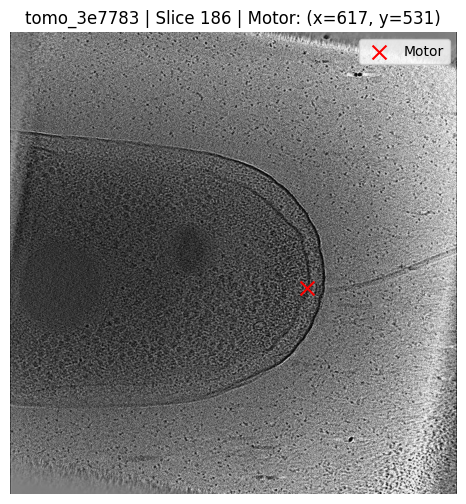

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Define path to tomogram
tomo_dir = os.path.join("sampled_train", "tomo_3e7783")

# Motor position
z, y, x = int(186), int(531), int(617)
slice_file = f"slice_{z:04d}.jpg"
img_path = os.path.join(tomo_dir, slice_file)

# Load and plot the image with the motor location
img = Image.open(img_path)

plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.scatter([x], [y], color='red', marker='x', s=100, label='Motor')
plt.title(f"tomo_3e7783 | Slice {z} | Motor: (x={x}, y={y})")
plt.axis('off')
plt.legend()
plt.show()

Number of tomograms: 648
count    648.000000
mean       1.137346
std        0.651685
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       10.000000
Name: count, dtype: float64


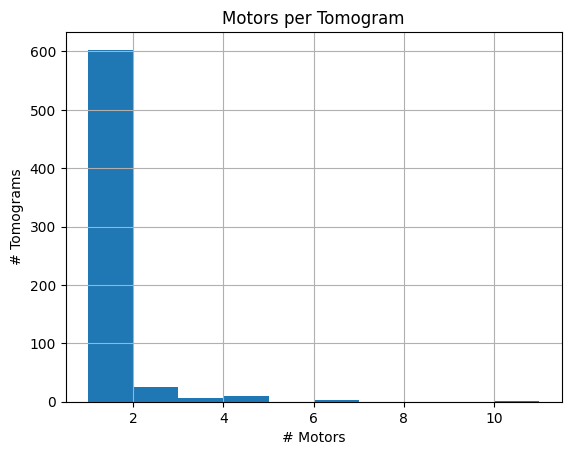

In [ ]:
import matplotlib.pyplot as plt

# How many unique tomograms?
print("Number of tomograms:", df['tomo_id'].nunique())

# Motor count per tomogram
motor_counts = df['tomo_id'].value_counts()
print(motor_counts.describe())

# Histogram
motor_counts.hist(bins=range(1, motor_counts.max()+2))
plt.title("Motors per Tomogram")
plt.xlabel("# Motors")
plt.ylabel("# Tomograms")
plt.show()

In [ ]:
print(df.columns.tolist())

['row_id', 'tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2', 'Array shape (axis 0)', 'Array shape (axis 1)', 'Array shape (axis 2)', 'Voxel spacing', 'Number of motors']


In [ ]:
df.columns = df.columns.str.strip()
df.columns

Index(['row_id', 'tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2',
       'Array shape (axis 0)', 'Array shape (axis 1)', 'Array shape (axis 2)',
       'Voxel spacing', 'Number of motors'],
      dtype='object')